In [101]:
#library('SPEI')
source('~/GitHub/climate_tools/spei.r')
source('../R/get_data.R')
#source('../R/derive_climate.R')

## JRN NPP sites

In [102]:
# Get daily data for grassland, creosote, and mesquite NPP sites at JRN
sites <- c('G-IBPE','G-SUMM','G-BASN','C-SAND','C-GRAV','C-CALI','M-NORT','M-WELL','M-RABB')
# These are the package IDs for daily data from each site on EDI
pkgids <- c(210437050, 210437051, 210437049, 210437048, 210437047, 210437046, 210437052, 210437054, 210437053)

# Creating a list of dataframes loaded from EDI
df_list <- list()
for (s in 1:length(sites)){
    df <- from_edi(pkgids[s], 0, scope='knb-lter-jrn', skip=3)
    df_list[[s]] <- df
}
# Assign site names to the list
names(df_list) <- sites

Rows: 3221 Columns: 52
── Column specification ─────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (23): Flag_RECORD, Flag_Batt_V_Min, Flag_Ptemp_C_Avg, Flag_Air_TempC_Av...
dbl  (27): Year, YearDay, Hours, RECORD, Sitename, Batt_V_Min, Ptemp_C_Avg, ...
dttm  (1): Batt_V_TMn
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3233 Columns: 78
── Column specification ─────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (35): Flag_RECORD, Flag_Batt_V_Min, Flag_Ptemp_C_Avg, Flag_Air_TempC_Av...
dbl  (39): Year, YearDay, Hours, RECORD, Sitename, Batt_V_Min, Ptemp_C_Avg, ...
dttm  (3): Batt_V_TMn, Solar_incoming_TMx, Solar_incoming_TMn
date  (1): Date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this

In [103]:
# What do the variables and data look like?
print(names(df_list$`C-CALI`))
head(df_list$`C-CALI`)

 [1] "Date"                         "Year"                        
 [3] "YearDay"                      "Hours"                       
 [5] "RECORD"                       "Flag_RECORD"                 
 [7] "Sitename"                     "Batt_V_Min"                  
 [9] "Flag_Batt_V_Min"              "Batt_V_TMn"                  
[11] "Ptemp_C_Avg"                  "Flag_Ptemp_C_Avg"            
[13] "Air_TempC_Avg"                "Flag_Air_TempC_Avg"          
[15] "Air_TempC_Max"                "Flag_Air_TempC_Max"          
[17] "Air_TempC_Min"                "Flag_Air_TempC_Min"          
[19] "Relative_Humidity_Avg"        "Flag_Relative_Humidity_Avg"  
[21] "Relative_Humidity_Max"        "Flag_Relative_Humidity_Max"  
[23] "Relative_Humidity_Min"        "Flag_Relative_Humidity_Min"  
[25] "Ppt_mm_Tot"                   "Flag_Ppt_mm_Tot"             
[27] "Ws_Mean_300cm"                "Flag_Ws_Mean_300cm"          
[29] "Ws_mean_Resultant_300cm"      "Flag_Ws_mean_Resultant_30

Date,Year,YearDay,Hours,RECORD,Flag_RECORD,Sitename,Batt_V_Min,Flag_Batt_V_Min,Batt_V_TMn,⋯,WS_ms_150cm_Max,Flag_WS_ms_150cm_Max,WS_ms_300cm_Max,Flag_WS_ms_300cm_Max,WS_ms_75cm_Min,Flag_WS_ms_75cm_Min,WS_ms_150cm_Min,Flag_WS_ms_150cm_Min,WS_ms_300cm_Min,Flag_WS_ms_300cm_Min
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dttm>,⋯,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>
2013-11-05,2013,309,23.9997,106,A,300,12.61,A,2013-11-05 06:16:42,⋯,13.870,A,14.530,A,0,A,0,A,0,A
2013-11-06,2013,310,23.9997,107,A,300,12.43,A,2013-11-06 04:58:55,⋯,10.110,A,10.060,A,0,A,0,A,0,A
2013-11-07,2013,311,23.9997,108,A,300,12.52,A,2013-11-07 23:43:44,⋯,8.600,A,10.060,A,0,A,0,A,0,A
2013-11-08,2013,312,23.9997,109,A,300,12.37,A,2013-11-08 06:48:37,⋯,5.594,A,6.342,A,0,A,0,A,0,A
2013-11-09,2013,313,23.9997,110,A,300,12.56,A,2013-11-09 06:22:44,⋯,5.594,A,5.598,A,0,A,0,A,0,A
2013-11-10,2013,314,23.9997,111,A,300,12.49,A,2013-11-10 06:14:41,⋯,6.346,A,7.086,A,0,A,0,A,0,A


In [104]:
# Function to convert daily to monthly data and calculate SPEI
library(tidyverse)
library(lubridate)

# Calculate monthly temp and precip
monthly_derived <- function(df, sitename, latitude=32.6169){
    # Convert to monthly data
    dfm <- df %>% mutate(
        Month = month(Date)) %>%
      group_by(Year, Month) %>%
      summarize(tavg = mean(Air_TempC_Avg, na.rm=T), #note the NA remove
                ppt = sum(Ppt_mm_Tot, na.rm=T)) # note the NA remove
    # SPEI can throw errors
    tryCatch({
        pet <- thornthwaite(dfm$tavg, latitude)
        # Prepare datetime index
        dateidx <- as.yearmon(paste(dfm$Month, '/', dfm$Year, sep=''), "%m/%Y")
        # Precip and PET timeseries
        prcp_xts <- xts(dfm$ppt, order.by=dateidx)
        pet_xts <- xts(as.numeric(pet), order.by=dateidx)
        # Climatic water differential
        cwdiff <- get_cwdiff(prcp_xts, pet_xts)
    
        # Now get 1year SPEI and extract values
        spei_12mo <- get_spei(cwdiff, int_per=12)  
        spei_xts <- xts(as.vector(spei_12mo$fitted),  order.by=index(cwdiff))
        colnames(spei_xts) <- c('spei12mo')
        # Add SPEI values
        dfm['spei12mo'] <- as.vector(spei_xts$spei12mo)
        },
        error=function(e){
            message('An Error Occurred')
            print(e)
        })
    # If we couldn't calculate SPEI, assign the column NA
    if (!('spei12mo' %in% names(dfm))){
        dfm['spei12mo'] <- NA
        }
    dfm['sitename'] <- sitename
    return(dfm)
}

`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


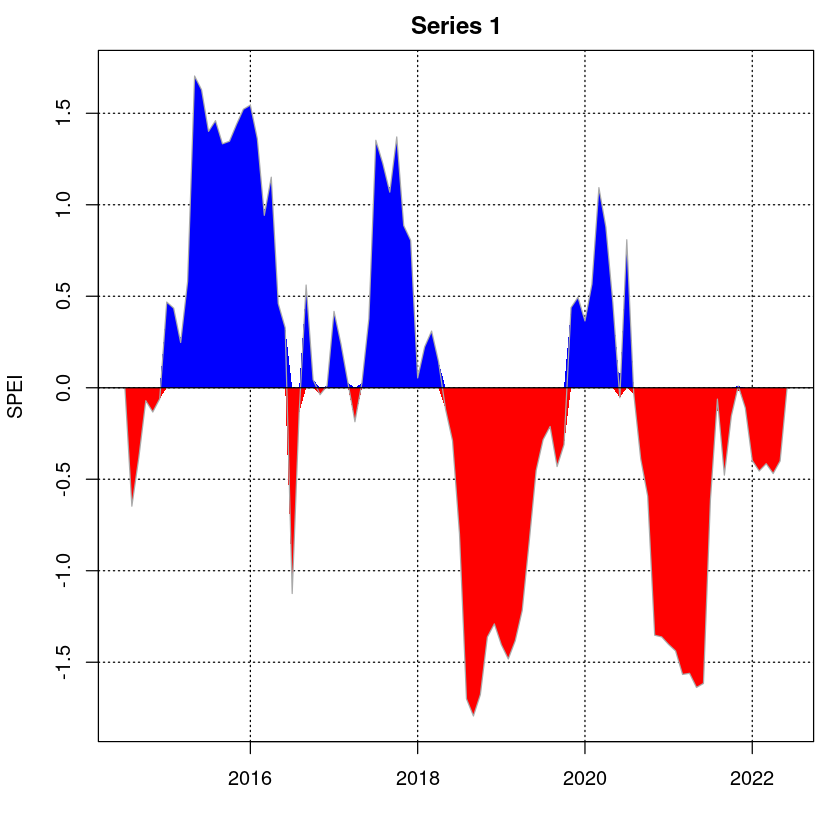

In [105]:
test <- monthly_derived(df_list$`G-IBPE`, 'IBPE')

In [106]:
tail(test)

Year,Month,tavg,ppt,spei12mo,sitename
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2021,12,8.110323,5.0,-0.1105635,IBPE
2022,1,4.172258,2.4,-0.3975199,IBPE
2022,2,5.416429,1.2,-0.4552929,IBPE
2022,3,10.953548,5.5,-0.4150539,IBPE
2022,4,18.893000,0.0,-0.4689679,IBPE
2022,5,23.556129,0.0,-0.4000575,IBPE


[1] 1
[1] "G-IBPE"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


[1] 2
[1] "G-SUMM"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.
An Error Occurred



<simpleError in thornthwaite(dfm$tavg, latitude): Data must not contain NAs>
[1] 3
[1] "G-BASN"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.
An Error Occurred



<simpleError in thornthwaite(dfm$tavg, latitude): Data must not contain NAs>
[1] 4
[1] "C-SAND"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


[1] 5
[1] "C-GRAV"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


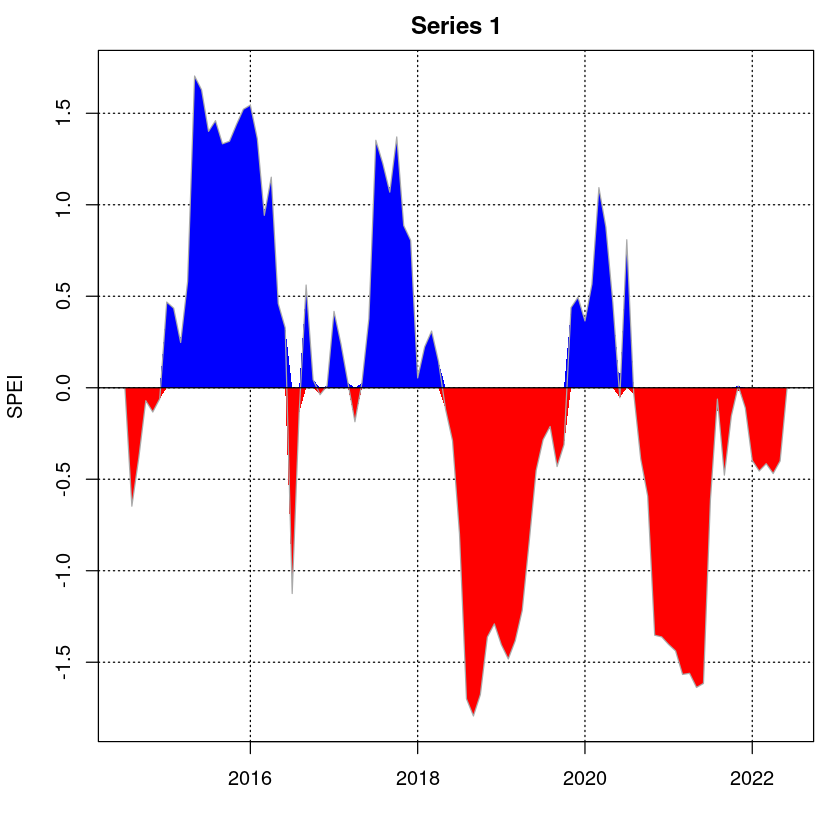

[1] 6
[1] "C-CALI"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


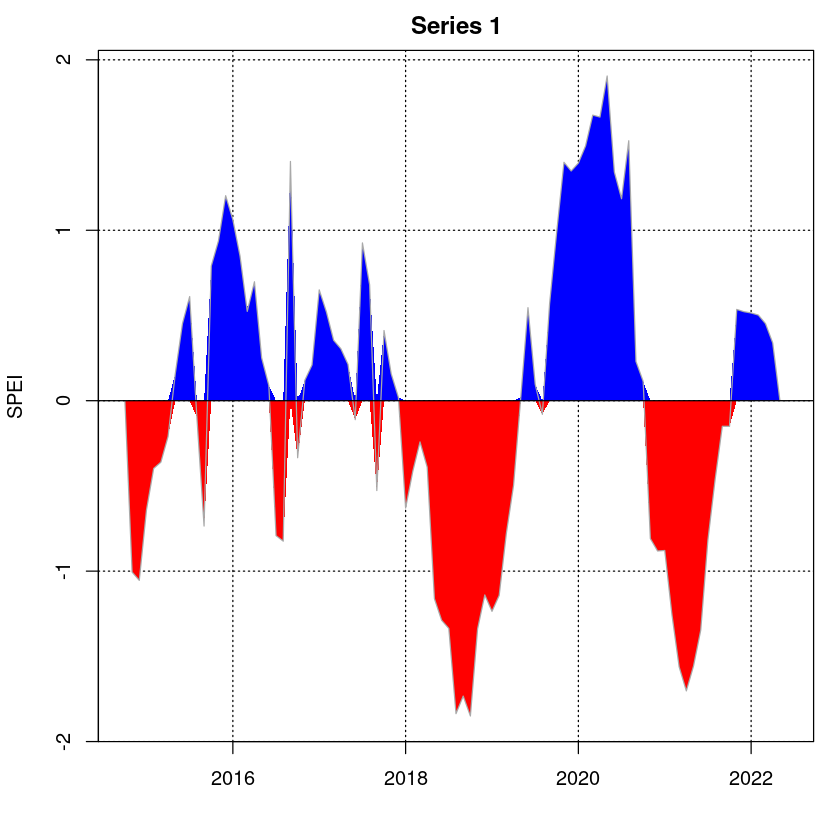

[1] "WARNING!!! - there are invalid values in the SPEI series"
[1] 7
[1] "M-NORT"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.
An Error Occurred



<simpleError in thornthwaite(dfm$tavg, latitude): Data must not contain NAs>
[1] 8
[1] "M-WELL"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.
An Error Occurred



<simpleError in thornthwaite(dfm$tavg, latitude): Data must not contain NAs>
[1] 9
[1] "M-RABB"


`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.


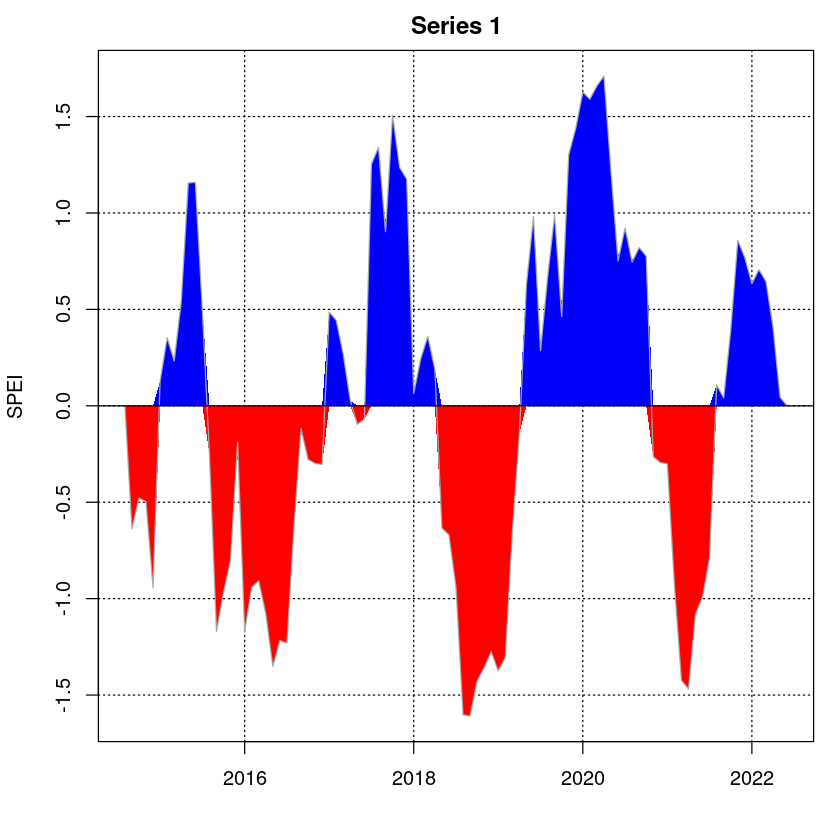

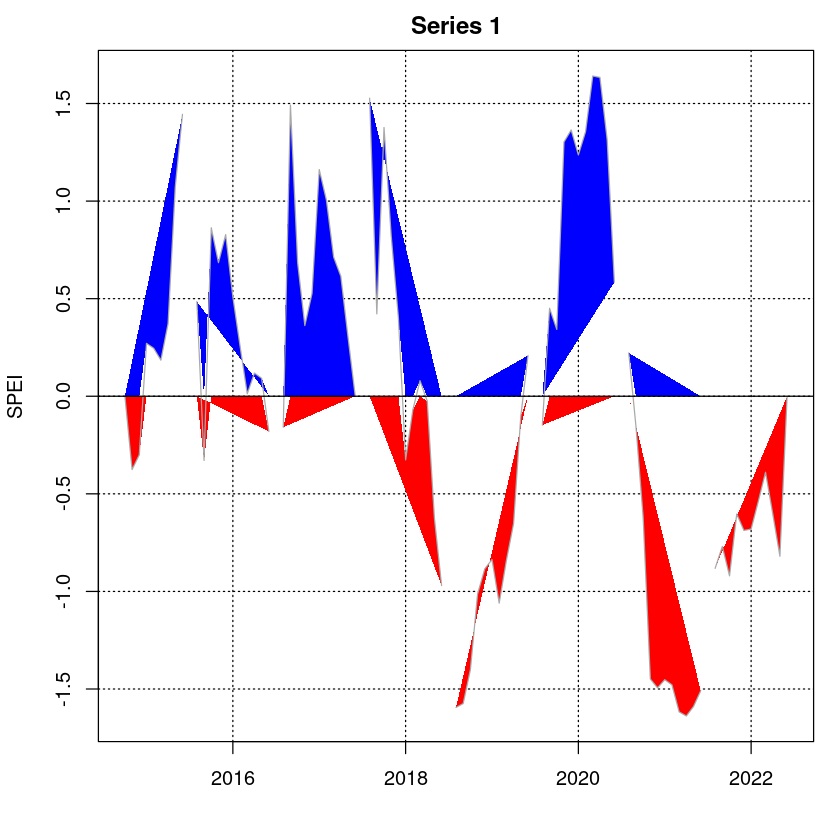

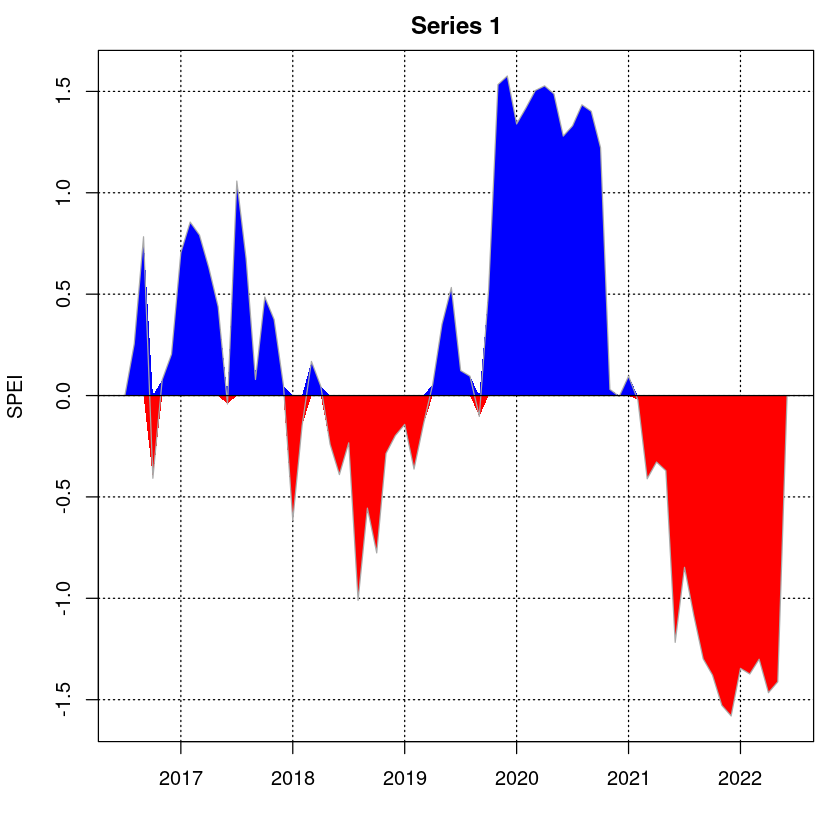

In [110]:
# Now loop through all 9 sites, do conversions and SPEI calcs and then
# bind into one big file.
for (i in 1:length(sites)){
    print(i)
    site <- sites[i]
    print(site)
    df <- monthly_derived(df_list[[site]], substr(site, 3, 7))
    if (i==1){
        df_all <- df
    } else {
        df_all <- bind_rows(df_all, df)
    }
}

In [112]:
write_csv(df_all, file = '../data/derived_monthly_climate_test.csv')

## Headquarters met data

In [15]:
# This is an API call to got GHCN monthly data
HQ_request <- 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-summary-of-the-month&dataTypes=PRCP,TMAX,TMIN,TAVG&stations=USC00294426&startDate=1914-01-01&endDate=2022-01-02'

In [16]:
hq <- read_csv(HQ_request)

Rows: 1254 Columns: 6
── Column specification ─────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): STATION, DATE
dbl (4): PRCP, TAVG, TMAX, TMIN

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
head(hq)

STATION,DATE,PRCP,TAVG,TMAX,TMIN
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
USC00294426,1914-06,75.6,26.83,36.37,17.28
USC00294426,1914-07,76.0,24.20,31.65,16.76
USC00294426,1914-08,12.4,25.01,34.12,15.90
USC00294426,1914-09,15.5,23.00,31.43,14.56
USC00294426,1914-10,11.3,15.12,24.77,5.47
USC00294426,1914-11,10.1,10.18,19.55,0.81
